In [ ]:
import sys
!{sys.executable} -m pip install pyxlsb
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random


Este código implementa o algoritmo da "mochila" (knapsack algorithm) para encontrar as combinações ideais de itens a serem escolhidos em uma venda, considerando suas quantidades e valores.

A função knapsack itera sobre todas as possíveis combinações de itens, calculando o valor máximo que pode ser obtido com a capacidade atual da mochila. O valor máximo é armazenado na tabela t. Em seguida, um processo de retrocesso é realizado para determinar quais itens foram escolhidos.

In [2]:
# knapsack algorithm to get the combinations for each sale
# t - memoization table to keep track of values for each item
# wt - array of weights (quantities for each purchase)
# val - array of values (also quantitied for each purchase)
# W - maximum capacity of the knapsack (quantity of the sale)
# n - number of possible purchases
# items_picked - array to store de purchases chosen
# returns the purchases chosen
def knapsack(t, wt, val, W, n, items_picked):
  value = 0
  for i in range(n + 1):
      for j in range(W + 1):
          if i == 0 or j == 0:
            t[i][j] = 0
          elif wt[i - 1] <= j:
              t[i][j] = max(val[i - 1] + t[i - 1][j - wt[i - 1]], t[i - 1][j])
              value = t[i][j];
          else: t[i][j] = t[i - 1][j]

  position_at_j = W
  position_at_i = n

  value_at = t[position_at_i][position_at_j]

  while value_at != 0:
      if value_at == t[position_at_i-1][position_at_j]:
          position_at_i -= 1
      else:
          items_picked.append(position_at_i-1)
          position_at_i -= 1
          position_at_j = position_at_j - wt[position_at_i]
      value_at = t[position_at_i][position_at_j]
  return items_picked

Este código é uma função chamada get_purchases_for_sales, que tem como objetivo obter as compras possíveis para cada venda e executar o algoritmo da mochila (knapsack) para determinar as combinações ideais de itens para cada venda.



In [3]:
# get possible purchases for each sale and run the knapsack
# dataframe_purchases - the dataframe representing the purchases data
# dataframe_sales - the dataframe representing the sales data
# returns a dataframe representing the combinations found by the knapsack
def get_purchases_for_sales(dataframe_purchases, dataframe_sales):
  combinations = pd.DataFrame()
  for index, sales_row in dataframe_sales.iterrows():
      print(index)
      values = []
      weights = []
      # Filter dataframe_purchases for matching criteria
      filtered_purchases = dataframe_purchases[
          (dataframe_purchases['Cód. Cliente'] == sales_row['Cód. Cliente']) &
          (dataframe_purchases['Dt. Operação'] == sales_row['Dt. Operação']) &
          (dataframe_purchases['Cód. Corretora'] == sales_row['Cód. Corretora']) &
          (dataframe_purchases['Cód. Título'] == sales_row['Cód. Título'])
      ]
      for index, purchases_row in filtered_purchases.iterrows():
        values.append(purchases_row['Quantidade'])
        weights.append(purchases_row['Quantidade'])
      W = sales_row["Quantidade"]
      n = len(values)

      # Initialize the memoization table with -1
      t = [[-1 for i in range(W + 1)] for j in range(n + 1)]

      items_picked = knapsack(t, weights, values, W, n, [])
      if items_picked:
            indices_to_remove = filtered_purchases.iloc[items_picked].index
            selected_rows = filtered_purchases.iloc[items_picked].copy()

            selected_rows["Chave"] = sales_row["Chave"]
            # Calculate price variance
            price_variance = selected_rows['Preço'].var()
            # Aggregate selected rows if more than one
            if len(items_picked) > 1:
                aggregated_rows = selected_rows.groupby(['Cód. Cliente', 'Dt. Operação', 'Cód. Corretora', 'Cód. Título', 'Chave']).agg({
                    'Quantidade': 'sum',
                    'Valor Líquido': 'sum',
                    'Preço': 'mean'
                }).reset_index()

                dataframe_purchases = dataframe_purchases.drop(indices_to_remove)

                # Add the calculated price variance to the aggregated rows
                aggregated_rows['Preço Var'] = price_variance

                combinations = pd.concat([combinations, aggregated_rows])
            else:
                combinations = pd.concat([combinations, selected_rows])
  return combinations


Este código define uma função chamada calculate_profit, que calcula os lucros e a relação entre o valor líquido das vendas e das compras para cada combinação presente no dataframe fornecido.

Em resumo, essa função é responsável por calcular os lucros e a relação entre os valores líquidos de vendas e compras para cada combinação encontrada no dataframe fornecido, usando uma fórmula que considera o período de tempo entre a operação e o vencimento e a taxa DI.

In [4]:
# calculate the cdi profit for each combination
# dataframe - the dataframe of the combinations with its respective sales
# returns a array with those profits and the ratio between the liquid value of sales and purchases
def calculate_profit(dataframe):
  profits = []
  sales_purchases_ratios = []
  for index, combination in dataframe.iterrows():
    ratio = combination["Valor Líquido Venda"] / abs(combination["Valor Líquido Compra"])
    sales_purchases_ratios.append(ratio)
    profit = ratio - 1
    du = abs((combination["Dt. Operação"] - combination["Vencimento"]).days)
    anual_profit = pow((1 + profit), 252 / du) - 1
    cdi_profit = anual_profit / combination["DI"]
    profits.append(cdi_profit*100)
  return profits, sales_purchases_ratios

Leituras dos arquivos das Bases de Compra em 2023

In [ ]:
df_purchase = pd.read_excel("../../data/base2023_compra.xlsb", engine="pyxlsb")
df_purchase_2 = pd.read_excel("../../data/base2023_compra_2.xlsb", engine="pyxlsb")

Este código converte as colunas de data dos dataframes df_purchase e df_purchase_2 para o formato datetime.

In [11]:
# change the date columns to pandas datetime
df_purchase_datetime = df_purchase.copy()
df_purchase_2_datetime = df_purchase_2.copy()

df_purchase_datetime['Dt. Operação'] = pd.to_datetime(df_purchase_datetime['Dt. Operação'], unit='D', origin='1899-12-30')
df_purchase_2_datetime['Dt. Operação'] = pd.to_datetime(df_purchase_2_datetime['Dt. Operação'], format="%d/%m/%Y")

df_purchase_2_datetime.rename(columns={"Vencimento": "Dt. Liquidação"}, inplace=True)

df_purchase_datetime['Dt. Liquidação'] = pd.to_datetime(df_purchase_datetime['Dt. Liquidação'], unit='D', origin='1899-12-30')
df_purchase_2_datetime['Dt. Liquidação'] = pd.to_datetime(df_purchase_2_datetime['Dt. Liquidação'], errors='coerce', format="%d/%m/%Y")

df_purchases = pd.concat([df_purchase_datetime, df_purchase_2_datetime], ignore_index=True)
df_purchases = df_purchases.sort_values(by=["Cód. Cliente", "Dt. Operação", "Cód. Título", "Cód. Corretora"]).reset_index()
pd.set_option('display.max_columns', None)

Leitura da base de Vendas em 2023

In [12]:
df_sales = pd.read_excel("../../data/base2023_venda.xlsb", engine="pyxlsb")

Código ajusta as colunas de data do dataframe df_sales, convertendo-as para o formato datetime e ordenando o dataframe com base em determinadas colunas.

In [13]:
df_sales_datetime = df_sales.copy()
df_sales_datetime['Dt. Operação'] = pd.to_datetime(df_sales_datetime['Dt. Operação'], unit='D', origin='1899-12-30')
df_sales_datetime['Vencimento'] = pd.to_datetime(df_sales_datetime['Vencimento'], unit='D', origin='1899-12-30')
df_sales_datetime = df_sales_datetime.sort_values(by=["Cód. Cliente", "Dt. Operação", "Cód. Título", "Cód. Corretora"]).reset_index()

Este código divide o dataframe df_sales_datetime em pedaços menores de tamanho n (2000 neste caso), criando uma lista chamada purchase_chunks. Cada elemento desta lista é um pedaço do dataframe original, onde o dataframe foi dividido em partes de tamanho n. Essa divisão é realizada utilizando list comprehension, iterando sobre o dataframe df_sales_datetime em intervalos de tamanho n.

In [ ]:
n=2000

#split DataFrame into chunks
purchase_chunks = [df_sales_datetime[i:i+n] for i in range(0,len(df_sales_datetime),n)]

# Casamento com tabelas brutas

Para obter análises estatísticas preliminares de possíveis resultados, decidimos como uma das estratégias apenas obter as compras e vendas que possuem a mesma quantidade (além das outras restrições como cliente, data da operação, corretora e título) a partir dos dados brutos, ou seja, apenas juntando as tabelas iniciais.

In [16]:
# merge the purchases and sales dataframes with the same quantities
df_same_quantities_brute = pd.merge(df_purchases, df_sales_datetime,
                                 on=['Cód. Cliente', 'Dt. Operação', 'Cód. Corretora', 'Cód. Título', 'Quantidade'],
                                 how='inner')

df_same_quantities_brute.rename(columns={"Valor Líquido_x": "Valor Líquido Compra"}, inplace=True)
df_same_quantities_brute.rename(columns={"Valor Líquido_y": "Valor Líquido Venda"}, inplace=True)

display(df_same_quantities_brute)

,index_x,Cód. Cliente,Dt. Operação,Tipo Operação_x,Cód. Título,Cód. Corretora,Quantidade,Preço_x,Valor Líquido Compra,Dt. Liquidação,Tipo_x,index_y,Chave,Tipo Operação_y,Preço_y,Valor Líquido Venda,Vencimento,Tipo_y,DI
0,168532,Cliente 12,2023-01-03,C,BBDC4,XPIN,2000,14.031735,-28063.470000,2023-01-05,AV,26428,26429A,V,14.241570,28483.14,2023-02-17,TE,0.136649
1,1278322,Cliente 12,2023-01-03,C,NUBR33,XPIN,600,3.179770,-1907.861901,NaT,AV,41475,41476A,V,3.263200,1957.92,2023-02-17,TE,0.136649
2,1278326,Cliente 12,2023-01-03,C,NUBR33,XPIN,600,3.196157,-1917.694105,NaT,AV,41475,41476A,V,3.263200,1957.92,2023-02-17,TE,0.136649
3,1278353,Cliente 12,2023-01-03,C,NUBR33,XPIN,600,2.944440,-1766.663947,NaT,AV,41475,41476A,V,3.263200,1957.92,2023-02-17,TE,0.136649
4,778127,Cliente 12,2023-01-03,C,VIVT3,XPIN,100,35.988500,-3598.850000,2023-01-05,AV,26366,26367A,V,40.935700,4093.57,2024-01-02,TE,0.136990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,899952,Cliente 6,2023-08-10,C,MGLU3,BRAD,800,3.340537,-2672.429570,NaT,AV,15091,15092A,V,3.024438,2419.55,2023-12-08,TE,0.125952
2412,931693,Cliente 6,2023-08-10,C,VALE3,BRAD,500,67.634702,-33817.351097,NaT,AV,13432,13433A,V,66.696880,33348.44,2023-09-11,TE,0.131284
2413,931693,Cliente 6,2023-08-10,C,VALE3,BRAD,500,67.634702,-33817.351097,NaT,AV,13433,13434A,V,66.706840,33353.42,2023-09-11,TE,0.131284
2414,931707,Cliente 6,2023-08-10,C,VALE3,BRAD,500,67.216567,-33608.283607,NaT,AV,13432,13433A,V,66.696880,33348.44,2023-09-11,TE,0.131284


O código profits_brute, ratios_brute = calculate_profit(df_same_quantities_brute) calcula os lucros e as razões entre os valores líquidos de vendas e compras para o dataframe df_same_quantities_brute utilizando a função calculate_profit definida anteriormente. A seguir, print(profits_brute) e print(ratios_brute) exibem os valores de lucros e razões calculados, respectivamente.



In [ ]:
profits_brute, ratios_brute = calculate_profit(df_same_quantities_brute)
print(profits_brute)
print(ratios_brute)

KeyError: 'DI'

# Geração de soluções possíveis utilizando o método da mochila

Outra estratégia foi criar combinações utilizando o problema da mochila, que consiste em escolher items para colocar na mochila que maximizem seu valor, mas não ultrapassem seu limite de peso. No caso, tanto os pesos quanto os valores são as quantidades de cada compra e a capacidade máxima é a quantidade da venda. Assim, compras são escolhidas para uma certa venda, gerando uma combinação.

Foram gerados 3 experimentos com partes da tabela de vendas (2000 linhas cada) para comparar os resultados finais.

## Experimento 1

Este trecho de código executa o algoritmo da mochila (knapsack) para um conjunto de vendas representado pelo primeiro chunk (purchase_chunks[0]).

In [ ]:
# runs the knapsack for a chunk of sales
temp_df_purchases = df_purchases.copy(deep=True)
combinations_purchases = get_purchases_for_sales(temp_df_purchases, purchase_chunks[0])
display(combinations_purchases)

In [ ]:
combinations_purchases = combinations_purchases.drop(['index', 'Tipo Operação', 'Dt. Liquidação', 'Tipo'], axis=1)

A célula abaixo lê o csv com o resultado do knapsack para agilizar análises futuras.

In [ ]:
combinations_purchases = pd.read_csv("resultados_knapsack/resultado-1.csv")
combinations_purchases = combinations_purchases.drop(['Unnamed: 0'], axis=1)
combinations_purchases["Dt. Operação"] = pd.to_datetime(combinations_purchases['Dt. Operação'], format="%Y-%m-%d")
display(combinations_purchases)

Este trecho combina os dataframes combinations_purchases e purchase_chunks[0] com base em certas chaves e renomeia as colunas resultantes para refletir as quantidades e valores de compra e venda.






In [ ]:
# merge the combinations dataframe with the sales by the keys
df_purchases_sales_agg = pd.merge(combinations_purchases, purchase_chunks[0], on=['Cód. Cliente', 'Dt. Operação', 'Cód. Corretora', 'Cód. Título', 'Chave'])

df_purchases_sales_agg.rename(columns={"Quantidade_x": "Qtd. Compra"}, inplace=True)
df_purchases_sales_agg.rename(columns={"Quantidade_y": "Qtd. Venda"}, inplace=True)
df_purchases_sales_agg.rename(columns={"Valor Líquido_x": "Valor Líquido Compra"}, inplace=True)
df_purchases_sales_agg.rename(columns={"Valor Líquido_y": "Valor Líquido Venda"}, inplace=True)

display(df_purchases_sales_agg)

,Cód. Cliente,Dt. Operação,Cód. Corretora,Cód. Título,Chave,Qtd. Compra,Valor Líquido Compra,Preço_x,Preço Var,index,Tipo Operação,Qtd. Venda,Preço_y,Valor Líquido Venda,Vencimento,Tipo,DI
0,Cliente 1,2023-01-05,XPIN,XPBR31,4721A,4400,-3.550963e+05,81.507432,75.242871,4720,V,4470,76.450544,341733.93,2023-03-21,TE,0.136781
1,Cliente 1,2023-01-05,XPIN,XPBR31,19007A,34900,-2.702697e+06,80.536549,54.273600,19006,V,35530,76.440559,2715933.07,2023-03-21,TE,0.136781
2,Cliente 1,2023-01-19,XPIN,XPBR31,18899A,17000,-1.577318e+06,91.645519,41.269410,18898,V,41230,86.807599,3579077.32,2023-02-22,TE,0.136585
3,Cliente 1,2023-02-16,XPIN,XPBR31,18902A,17200,-1.483312e+06,86.279829,49.308689,18901,V,38000,82.670646,3141484.55,2023-04-17,TE,0.136490
4,Cliente 1,2023-02-17,XPIN,XPBR31,7066A,3602,-2.568869e+05,69.837171,14.907290,7065,V,3610,66.462501,239929.63,2023-03-06,TE,0.136531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1597,Cliente 12,2023-04-25,XPIN,GUAR3,29327A,900,-3.735646e+03,4.253100,0.188682,29326,V,912,4.244156,3870.67,2023-05-11,TE,0.136549
1598,Cliente 12,2023-04-25,XPIN,ITUB4,43987A,2600,-7.155079e+04,27.276378,2.507031,43986,V,2630,25.940186,68222.69,2023-06-20,TE,0.136347
1599,Cliente 12,2023-04-25,XPIN,ITUB4,43988A,7300,-1.910343e+05,26.382854,3.836692,43987,V,7370,25.950022,191251.66,2023-06-20,TE,0.136347
1600,Cliente 12,2023-04-25,XPIN,JHSF3,3793A,200,-8.147208e+02,4.073604,NaN,3792,V,298,3.703456,1103.63,2023-05-25,TE,0.136492



Este trecho de código cria um novo dataframe chamado df_same_quantities, contendo apenas as combinações em que as quantidades de compra são iguais às quantidades de venda. Isso é realizado filtrando o dataframe df_purchases_sales_agg com a condição df_purchases_sales_agg['Qtd. Compra'] == df_purchases_sales_agg['Qtd. Venda'].

Em seguida, o código exibe o dataframe df_same_quantities utilizando a função display(), mostrando apenas as combinações onde as quantidades de compra e venda são iguais.



In [ ]:
# obtain the combinations which have the same quantities as sales
df_same_quantities = df_purchases_sales_agg[df_purchases_sales_agg['Qtd. Compra'] == df_purchases_sales_agg['Qtd. Venda']]
display(df_same_quantities)

,Cód. Cliente,Dt. Operação,Cód. Corretora,Cód. Título,Chave,Qtd. Compra,Valor Líquido Compra,Preço_x,Preço Var,index,Tipo Operação,Qtd. Venda,Preço_y,Valor Líquido Venda,Vencimento,Tipo,DI
11,Cliente 1,2023-03-02,XPIN,XPBR31,9858A,14900,-9.653477e+05,65.087508,30.879452,9857,V,14900,61.249689,9.126204e+05,2023-04-03,TE,0.136500
13,Cliente 1,2023-03-14,XPIN,XPBR31,9860A,13228,-7.779148e+05,58.934723,0.239188,9859,V,13228,60.339953,7.981769e+05,2023-05-15,TE,0.136211
14,Cliente 1,2023-03-14,XPIN,XPBR31,9861A,86772,-5.136823e+06,58.826202,0.176981,9860,V,86772,60.329974,5.234952e+06,2023-05-15,TE,0.136211
15,Cliente 1,2023-03-30,XPIN,XPBR31,9862A,1000,-7.031939e+04,69.655391,5.511123,9861,V,1000,63.664820,6.366482e+04,2023-06-28,TE,0.136271
16,Cliente 1,2023-03-30,XPIN,XPBR31,9863A,19000,-1.301506e+06,67.956086,30.866812,9862,V,19000,63.674773,1.209821e+06,2023-06-28,TE,0.136271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557,Cliente 12,2023-04-24,CONC,VALE3,41955A,400,-2.948493e+04,73.712324,NaN,41954,V,400,72.685725,2.907429e+04,2023-05-23,TE,0.136462
1560,Cliente 12,2023-04-24,CONC,VALE3,41959A,4600,-3.461359e+05,75.678212,15.537665,41958,V,4600,72.695528,3.343994e+05,2023-05-23,TE,0.136462
1567,Cliente 12,2023-04-25,XPIN,ALPA4,29314A,5100,-3.833380e+04,7.537660,0.387961,29313,V,5100,7.030276,3.585441e+04,2023-05-11,TE,0.136549
1582,Cliente 12,2023-04-25,XPIN,CYRE3,43985A,8600,-1.352709e+05,16.175205,1.791284,43984,V,8600,15.149227,1.302834e+05,2023-06-20,TE,0.136347


In [ ]:
profits, ratios = calculate_profit(df_same_quantities)
print(profits)
print(ratios)

[-261.87449591389765, 80.8810567143387, 58.69421552389041, -178.30457559433728, -135.74227032406702, 62.3649311786464, 39.493171855108585, 63.43011849949482, -483.6177489933247, -375.26791426359597, 125.95257465513, 90.21525835445884, 68.08383064001937, -478.77169435615974, -426.13353160413743, -419.8884160568282, 786.2022879262241, -12.438670622980284, -86.18621632005491, -58.46382732728881, -221.77704313141797, -109.91447727628314, -399.64512518252275, -122.66428590489863, -166.43866633150077, -95.72235940121459, -231.9387572416573, -99.49691945717815, -319.4083995815115, -147.1156251680165, -341.7485746993949, -427.43340004311744, -268.2549673393582, -150.34036816781844, 63.376692993407744, -15.053680385765825, -370.46188377581336, -40.925523822485104, -10.576941107116934, -248.62139636772463, -182.14882115381388, -287.600821987532, -306.2834686247071, -222.57295842443474, -472.95983455651276, -152.73197740158454, -204.00106426360418, -195.83743415035354, -108.40361418369378, 68.524

## Experimento 2

In [ ]:
temp_df_purchases = df_purchases.copy(deep=True)
random_chunk = random.randrange(1, len(purchase_chunks))
print(random_chunk)
combinations_purchases = get_purchases_for_sales(temp_df_purchases, purchase_chunks[random_chunk])
display(combinations_purchases)

In [ ]:
combinations_purchases_2 = combinations_purchases_2.drop(['index', 'Tipo Operação', 'Dt. Liquidação', 'Tipo'], axis=1)

KeyError: "['index', 'Tipo Operação', 'Dt. Liquidação', 'Tipo'] not found in axis"

A célula abaixo lê o csv com o resultado do knapsack para agilizar análises futuras.

In [ ]:
combinations_purchases_2 = pd.read_csv("resultados_knapsack/resultado-2.csv")
combinations_purchases_2 = combinations_purchases_2.drop(['Unnamed: 0'], axis=1)
combinations_purchases_2["Dt. Operação"] = pd.to_datetime(combinations_purchases_2['Dt. Operação'], format="%Y-%m-%d")
random_chunk = 20
display(combinations_purchases_2)

,Cód. Cliente,Dt. Operação,Cód. Corretora,Cód. Título,Chave,Quantidade,Valor Líquido,Preço,Preço Var
0,Cliente 4,2023-08-01,XPIN,ELET3,42501A,900,-37395.815395,40.085497,7.099644
1,Cliente 4,2023-08-01,XPIN,ELET3,42502A,900,-37978.642721,40.524605,50.434173
2,Cliente 4,2023-08-01,XPIN,ELET3,42503A,800,-28205.781821,35.257227,NaN
3,Cliente 4,2023-08-01,XPIN,ELET3,42504A,2100,-79261.647359,37.519745,0.902338
4,Cliente 4,2023-08-01,XPIN,GOLL4,22449A,900,-8760.618506,9.728065,0.005746
...,...,...,...,...,...,...,...,...,...
1304,Cliente 4,2023-10-30,XPIN,USIM5,15718A,10,-65.290000,6.529000,NaN
1305,Cliente 4,2023-10-30,XPIN,USIM5,15719A,910,-7148.260177,7.433087,0.446316
1306,Cliente 4,2023-10-31,XPIN,BBAS3,18059A,100,-5017.678808,50.176788,NaN
1307,Cliente 4,2023-10-31,XPIN,BBAS3,18060A,800,-38882.080000,48.602600,NaN


In [ ]:
df_purchases_sales_agg_2 = pd.merge(combinations_purchases_2, purchase_chunks[random_chunk], on=['Cód. Cliente', 'Dt. Operação', 'Cód. Corretora', 'Cód. Título', 'Chave'])

df_purchases_sales_agg_2.rename(columns={"Quantidade_x": "Qtd. Compra"}, inplace=True)
df_purchases_sales_agg_2.rename(columns={"Quantidade_y": "Qtd. Venda"}, inplace=True)
df_purchases_sales_agg_2.rename(columns={"Valor Líquido_x": "Valor Líquido Compra"}, inplace=True)
df_purchases_sales_agg_2.rename(columns={"Valor Líquido_y": "Valor Líquido Venda"}, inplace=True)

display(df_purchases_sales_agg_2)

,Cód. Cliente,Dt. Operação,Cód. Corretora,Cód. Título,Chave,Qtd. Compra,Valor Líquido Compra,Preço_x,Preço Var,index,Tipo Operação,Qtd. Venda,Preço_y,Valor Líquido Venda,Vencimento,Tipo,DI
0,Cliente 4,2023-08-01,XPIN,ELET3,42501A,900,-37395.815395,40.085497,7.099644,42500,V,928,37.922759,35192.32,2023-08-17,TE,0.134424
1,Cliente 4,2023-08-01,XPIN,ELET3,42502A,900,-37978.642721,40.524605,50.434173,42501,V,935,37.932738,35467.11,2023-08-17,TE,0.134424
2,Cliente 4,2023-08-01,XPIN,ELET3,42503A,800,-28205.781821,35.257227,NaN,42502,V,806,38.281861,30855.18,2023-08-17,TE,0.134424
3,Cliente 4,2023-08-01,XPIN,ELET3,42504A,2100,-79261.647359,37.519745,0.902338,42503,V,2194,38.291809,84012.23,2023-08-17,TE,0.134424
4,Cliente 4,2023-08-01,XPIN,GOLL4,22449A,900,-8760.618506,9.728065,0.005746,22448,V,976,9.445789,9219.09,2023-09-19,TE,0.132244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,Cliente 4,2023-10-30,XPIN,USIM5,15718A,10,-65.290000,6.529000,NaN,15717,V,27,6.627407,178.94,2024-01-02,TE,0.120760
1305,Cliente 4,2023-10-30,XPIN,USIM5,15719A,910,-7148.260177,7.433087,0.446316,15718,V,973,6.637451,6458.24,2024-01-02,TE,0.120760
1306,Cliente 4,2023-10-31,XPIN,BBAS3,18059A,100,-5017.678808,50.176788,NaN,18058,V,131,50.602519,6628.93,2024-02-28,TE,0.117932
1307,Cliente 4,2023-10-31,XPIN,BBAS3,18060A,800,-38882.080000,48.602600,NaN,18059,V,869,50.592348,43964.75,2024-02-28,TE,0.117932


In [ ]:
df_same_quantities_2 = df_purchases_sales_agg_2[df_purchases_sales_agg_2['Qtd. Compra'] == df_purchases_sales_agg_2['Qtd. Venda']]
display(df_same_quantities_2)

,Cód. Cliente,Dt. Operação,Cód. Corretora,Cód. Título,Chave,Qtd. Compra,Valor Líquido Compra,Preço_x,Preço Var,index,Tipo Operação,Qtd. Venda,Preço_y,Valor Líquido Venda,Vencimento,Tipo,DI
63,Cliente 4,2023-08-02,XPIN,NGRD3,16661A,3600,-7244.835720,2.045575,0.026445,16660,V,3600,1.846044,6645.76,2023-09-19,TE,0.132324
64,Cliente 4,2023-08-02,XPIN,NGRD3,16662A,6400,-12122.217328,1.927706,0.030682,16661,V,6400,1.856019,11878.52,2023-09-19,TE,0.132324
87,Cliente 4,2023-08-02,XPIN,VAMO3,43401A,1000,-11096.962916,11.253756,0.470293,43400,V,1000,11.794720,11794.72,2023-09-01,TE,0.133060
89,Cliente 4,2023-08-02,XPIN,VAMO3,43403A,4000,-49523.215486,12.386084,0.786979,43402,V,4000,11.804675,47218.70,2023-09-01,TE,0.133060
102,Cliente 4,2023-08-03,XPIN,AMAR3,143A,12800,-12597.095257,0.985127,0.006382,142,V,12800,0.928614,11886.26,2023-08-22,TE,0.131592
108,Cliente 4,2023-08-03,XPIN,GFSA3,43410A,200,-1296.804335,6.484022,NaN,43409,V,200,6.130850,1226.17,2023-09-04,TE,0.131472
119,Cliente 4,2023-08-03,XPIN,LJQQ3,24105A,13,-83.560000,6.416833,0.000813,24104,V,13,6.670769,86.72,2023-11-01,TE,0.129060
120,Cliente 4,2023-08-03,XPIN,LJQQ3,24106A,87,-562.980000,6.472739,0.003992,24105,V,87,6.680230,581.18,2023-11-01,TE,0.129060
181,Cliente 4,2023-08-08,XPIN,USIM5,592A,8900,-66234.317869,7.367231,0.265204,591,V,8900,7.034288,62605.16,2023-08-24,TE,0.131572
182,Cliente 4,2023-08-08,XPIN,USIM5,593A,1100,-8655.914701,7.845227,0.010644,592,V,1100,7.044273,7748.70,2023-08-24,TE,0.131572


In [ ]:
profits_2, ratios_2 = calculate_profit(df_same_quantities_2)
print(profits_2)
print(ratios_2)

[-275.3566791819086, -76.42692073162245, 502.79682313954373, -247.90617839104226, -408.19971948922847, -271.27044259833997, 84.86619220175068, 72.19488278207136, -447.1544454106554, -627.1462949021123, -32.07902350531451, -95.61897586295262, 74.5334053062465, -132.9864419169722, -348.94062202009775, 652.6991860880327, 553.3607187097506, -121.81855230279388, -211.62579171811336, 111.78727684794897, -328.50072749169124, -376.5189428240179, -644.2348602715426, -442.20240126706926, -140.18967538887176, 61.1289941199341, -124.4645115965662, 221.649840746129, -581.090591176736, 67.90725672543303, 70.1301275292124, -628.5527847494434, -551.7466584475255, -117.17455077868337, -117.17455077868337, -227.14701561709583, -569.3226733020917, -119.47744755112556, -39.38746105958803, -466.1308849681627]
[0.917309964942135, 0.9798966375804291, 1.0628782027133052, 0.9534659560506146, 0.9435714946700403, 0.9455320029362447, 1.0378171373863092, 1.03232796902199, 0.9452072885175858, 0.8951913538890606, 0.

## Experimento 3

In [ ]:
temp_df_purchases = df_purchases.copy(deep=True)
random_chunk = random.randrange(1, len(purchase_chunks))
print(random_chunk)
combinations_purchases_3 = get_purchases_for_sales(temp_df_purchases, purchase_chunks[random_chunk])
display(combinations_purchases_3)

In [ ]:
combinations_purchases_3 = combinations_purchases_3.drop(['index', 'Tipo Operação', 'Dt. Liquidação', 'Tipo'], axis=1)

A célula abaixo lê o csv com o resultado do knapsack para agilizar análises futuras.

In [ ]:
combinations_purchases_3 = pd.read_csv("resultados_knapsack/resultado-3.csv")
combinations_purchases_3 = combinations_purchases_3.drop(['Unnamed: 0'], axis=1)
combinations_purchases_3["Dt. Operação"] = pd.to_datetime(combinations_purchases_3['Dt. Operação'], format="%Y-%m-%d")
random_chunk = 10
display(combinations_purchases_3)

,Cód. Cliente,Dt. Operação,Cód. Corretora,Cód. Título,Chave,Quantidade,Valor Líquido,Preço,Preço Var
0,Cliente 21,2023-09-20,INDU,PETR3,26261A,1900,-75933.286967,39.805270,20.323025
1,Cliente 21,2023-09-21,CAPM,BPAC3,645A,4000,-57892.705125,14.760086,1.411915
2,Cliente 21,2023-09-21,CAPM,BPAC3,646A,1500,-21641.864258,14.188555,1.441952
3,Cliente 21,2023-09-21,INDU,COGN3,28590A,6000,-17550.620510,2.955326,0.062002
4,Cliente 21,2023-09-21,INDU,COGN3,28591A,10600,-30846.884209,2.928163,0.045863
...,...,...,...,...,...,...,...,...,...
1575,Cliente 23,2023-10-26,XPIN,DASA3,17690A,400,-3954.300000,9.885750,NaN
1576,Cliente 23,2023-10-26,XPIN,DASA3,17693A,100,-1001.687136,10.016871,NaN
1577,Cliente 23,2023-10-26,XPIN,DASA3,17694A,300,-2917.212956,9.724043,NaN
1578,Cliente 23,2023-10-26,XPIN,DASA3,17695A,400,-3954.300000,9.885750,NaN


In [ ]:
df_purchases_sales_agg_3 = pd.merge(combinations_purchases_3, purchase_chunks[random_chunk], on=['Cód. Cliente', 'Dt. Operação', 'Cód. Corretora', 'Cód. Título', 'Chave'])
#matched_rows = pd.merge(combinations_purchases, vendas_por_cliente_vencimento, on=['Cód. Cliente', 'Dt. Operação', 'Cód. Corretora', 'Cód. Título'])

df_purchases_sales_agg_3.rename(columns={"Quantidade_x": "Qtd. Compra"}, inplace=True)
df_purchases_sales_agg_3.rename(columns={"Quantidade_y": "Qtd. Venda"}, inplace=True)
df_purchases_sales_agg_3.rename(columns={"Valor Líquido_x": "Valor Líquido Compra"}, inplace=True)
df_purchases_sales_agg_3.rename(columns={"Valor Líquido_y": "Valor Líquido Venda"}, inplace=True)

display(df_purchases_sales_agg_3)

,Cód. Cliente,Dt. Operação,Cód. Corretora,Cód. Título,Chave,Qtd. Compra,Valor Líquido Compra,Preço_x,Preço Var,index,Tipo Operação,Qtd. Venda,Preço_y,Valor Líquido Venda,Vencimento,Tipo,DI
0,Cliente 21,2023-09-20,INDU,PETR3,26261A,1900,-75933.286967,39.805270,20.323025,26260,V,1990,37.976231,75572.70,2023-10-20,TE,0.125955
1,Cliente 21,2023-09-21,CAPM,BPAC3,645A,4000,-57892.705125,14.760086,1.411915,644,V,4059,14.190774,57600.35,2023-10-23,TE,0.126669
2,Cliente 21,2023-09-21,CAPM,BPAC3,646A,1500,-21641.864258,14.188555,1.441952,645,V,1541,14.180785,21852.59,2023-10-23,TE,0.126669
3,Cliente 21,2023-09-21,INDU,COGN3,28590A,6000,-17550.620510,2.955326,0.062002,28589,V,6008,2.817465,16927.33,2024-03-19,TE,0.118043
4,Cliente 21,2023-09-21,INDU,COGN3,28591A,10600,-30846.884209,2.928163,0.045863,28590,V,13992,2.827452,39561.71,2024-03-19,TE,0.118043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1575,Cliente 23,2023-10-26,XPIN,DASA3,17690A,400,-3954.300000,9.885750,NaN,17689,V,474,9.909916,4697.30,2023-11-21,TE,0.124167
1576,Cliente 23,2023-10-26,XPIN,DASA3,17693A,100,-1001.687136,10.016871,NaN,17692,V,186,9.929892,1846.96,2023-11-21,TE,0.124167
1577,Cliente 23,2023-10-26,XPIN,DASA3,17694A,300,-2917.212956,9.724043,NaN,17693,V,372,9.929892,3693.92,2023-11-21,TE,0.124167
1578,Cliente 23,2023-10-26,XPIN,DASA3,17695A,400,-3954.300000,9.885750,NaN,17694,V,451,9.959800,4491.87,2023-11-21,TE,0.124167


In [ ]:
df_same_quantities_3 = df_purchases_sales_agg_3[df_purchases_sales_agg_3['Qtd. Compra'] == df_purchases_sales_agg_3['Qtd. Venda']]
display(df_same_quantities_3)

,Cód. Cliente,Dt. Operação,Cód. Corretora,Cód. Título,Chave,Qtd. Compra,Valor Líquido Compra,Preço_x,Preço Var,index,Tipo Operação,Qtd. Venda,Preço_y,Valor Líquido Venda,Vencimento,Tipo,DI
47,Cliente 21,2023-09-22,INDU,VALE3,29546A,700,-4.763688e+04,68.052686,NaN,29545,V,700,69.297571,48508.30,2023-11-21,TE,0.125202
75,Cliente 21,2023-09-28,INDU,JSLG3,28596A,100,-9.948426e+02,9.948426,NaN,28595,V,100,8.344100,834.41,2023-11-27,TE,0.124596
76,Cliente 21,2023-09-28,INDU,JSLG3,28597A,9900,-8.839997e+04,8.969113,0.608868,28596,V,9900,8.354149,82706.08,2023-11-27,TE,0.124596
94,Cliente 21,2023-10-03,CAPM,BOVA11,3500A,9400,-1.131314e+06,119.345092,95.101011,3499,V,9400,110.867889,1042158.16,2023-11-03,TE,0.126421
114,Cliente 21,2023-10-03,PLAN,TRAD3,649A,6000,-6.373157e+03,1.045105,0.003667,648,V,6000,1.019287,6115.72,2023-11-03,TE,0.126421
122,Cliente 21,2023-10-05,PLAN,INBR32,651A,7061,-1.494197e+05,21.083680,2.710006,650,V,7061,20.415685,144155.15,2024-01-03,TE,0.122397
132,Cliente 21,2023-10-06,INDU,SEQL3,34066A,500,-2.922829e+02,0.584566,NaN,34065,V,500,0.499660,249.83,2023-12-05,TE,0.123685
159,Cliente 21,2023-10-11,PLAN,TRPL4,34077A,6800,-1.604451e+05,23.405412,2.750475,34076,V,6800,22.314368,151737.70,2023-11-24,TE,0.124545
160,Cliente 21,2023-10-11,PLAN,TRPL4,34078A,13200,-3.154233e+05,23.616743,5.450155,34077,V,13200,22.324363,294681.59,2023-11-24,TE,0.124545
174,Cliente 21,2023-10-16,INDU,CEAB3,20792A,5200,-2.986696e+04,5.801112,0.168331,20791,V,5200,5.276306,27436.79,2024-01-15,TE,0.121395


In [ ]:
profits_3, ratios_3 = calculate_profit(df_same_quantities_3)
print(profits_3)
print(ratios_3)

[63.185545048497225, -419.1317507913062, -195.7812851387567, -385.141133835794, -225.2720155857678, -78.06921498963779, -390.2742952041719, -219.63294780754237, -259.0649201571955, -172.5317936540184, 60.81790636014025, -94.81271209007286, -557.5204479223052, -65.08190196475087, -39.139702768765616, -126.79157152038702, -41.25156066981952, -266.1709339899717, -199.25575164588875, -77.06254547796253, -180.9422915099631, 3.251801600054861, -229.48526573467856, -33.974302488652405, -232.36807170934014, -30.42665272259543, -75.9985790435577, 218.4145147988983, -325.6010990233712, -77.22271103284832, 114.13861752536052, -60.02773785942321, 2.4176566753675566, -19.327169254405145, -62.06885186997374, 61.28712826708702, 68.60262789721861, 1.2875689401226504, -52.57021568973047, 46.9605255190846, -143.2584436644848, -148.95331836495433, -8.962618064769611, -81.28940962852876, -148.51172166568233, -61.08273006918715, -146.13068504467742, -434.3255430108144, -520.0901506330263, -61.2177334812041

# Gráficos

Para visualização da análise foram criados alguns gráficos de distribuição.

## Razão Valor Líquido Venda / Compra x Rentabilidade

Esse gráfico foi feito para analisar o impacto dos valores líquidos na rentabilidade com o intuito de considerar possíveis compras a serem retiradas de uma combinação com o objetivo de maximizar a rentabilidade por volta de 100% em alguma função de recompensa.

É possível observar que a rentabilidade tem uma tendência a aumentar conforme a razão aumenta. Dessa forma, compras com valores maiores, o que diminuiria a razão, poderiam ser priorizadas na remoção.

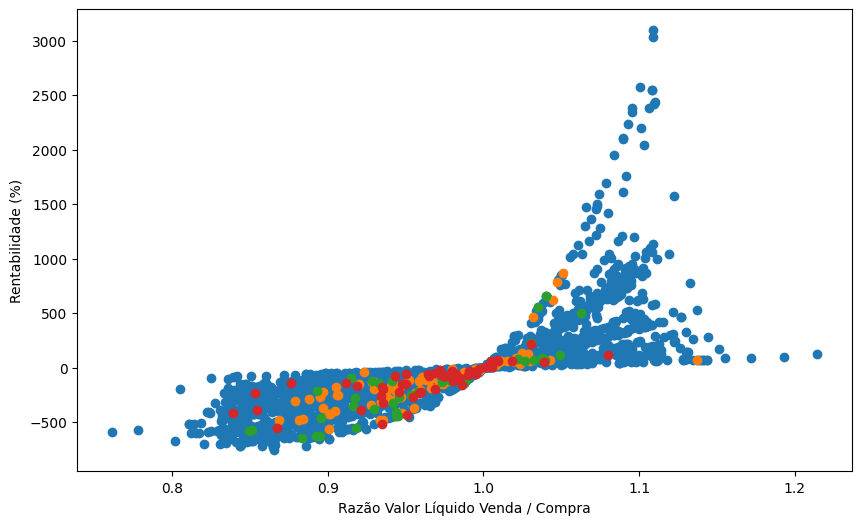

In [ ]:
# plot the profits by ratios of sales and purchases liquid value for the three experiments plus the brute one
plt.figure(figsize=(10, 6))

plt.scatter(ratios_brute, profits_brute)
plt.scatter(ratios, profits)
plt.scatter(ratios_2, profits_2)
plt.scatter(ratios_3, profits_3)

plt.ylabel('Rentabilidade (%)')
plt.xlabel('Razão Valor Líquido Venda / Compra')

plt.show()

## Distribuição das rentabilidades
Os gráficos abaixo representam a distribuição das rentabilidades (tanto histograma quanto em linha) para todos os casos. Apesar dos resultados estarem longe do ideal do 100% de rentabilidade, é possível perceber que o resultado segue uma certa distribuição de probabilidade.

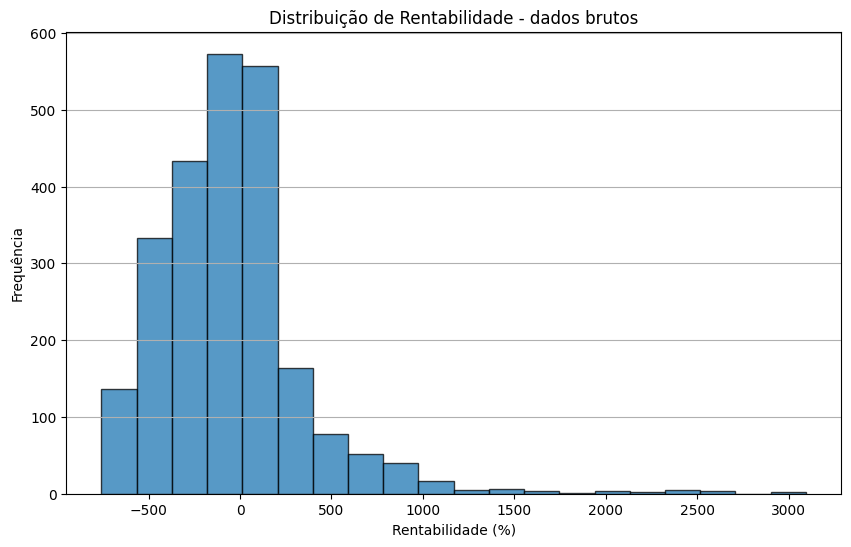

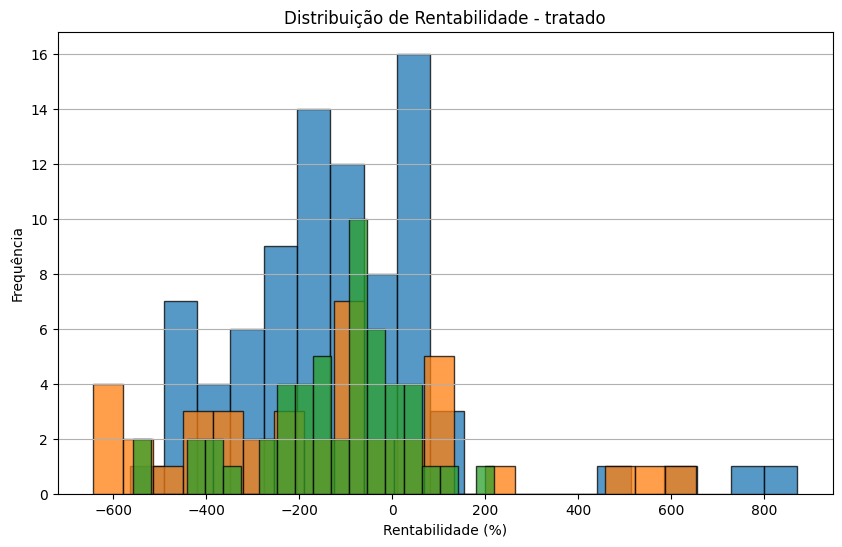

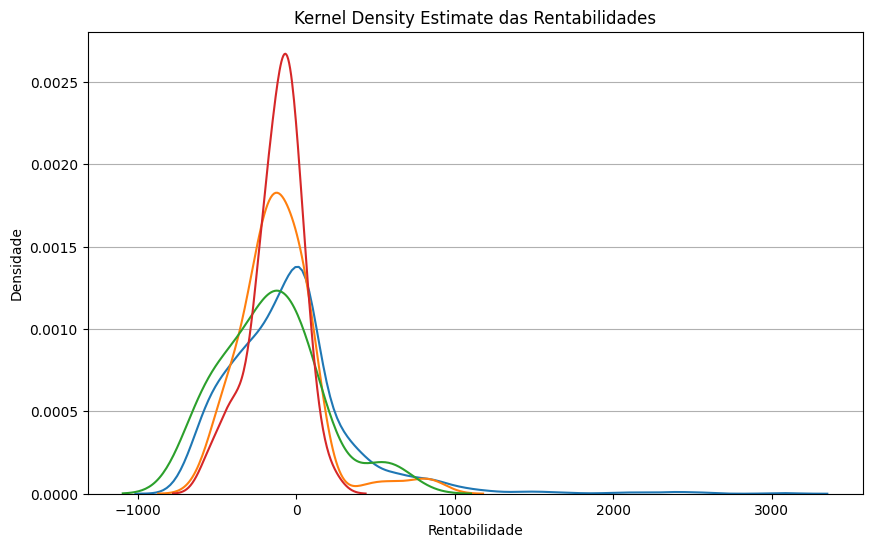

In [ ]:
# plot the histogram of the brute approach profits
plt.figure(figsize=(10, 6))

plt.hist(profits_brute, bins=20, alpha=0.75, edgecolor='black')
plt.title('Distribuição de Rentabilidade - dados brutos')
plt.xlabel('Rentabilidade (%)')
plt.ylabel('Frequência')
plt.grid(axis='y')
plt.show()

# plot the histogram for the three experiments profits
plt.figure(figsize=(10, 6))
plt.hist(profits, bins=20, alpha=0.75, edgecolor='black')
plt.hist(profits_2, bins=20, alpha=0.75, edgecolor='black')
plt.hist(profits_3, bins=20, alpha=0.75, edgecolor='black')

plt.title('Distribuição de Rentabilidade - tratado')
plt.xlabel('Rentabilidade (%)')
plt.ylabel('Frequência')
plt.grid(axis='y')
plt.show()

# plot the distribution for the four approaches
plt.figure(figsize=(10, 6))
sns.kdeplot(profits_brute, bw_adjust=1)
sns.kdeplot(profits, bw_adjust=1)
sns.kdeplot(profits_2, bw_adjust=1)
sns.kdeplot(profits_3, bw_adjust=1)
plt.title('Kernel Density Estimate das Rentabilidades')
plt.xlabel('Rentabilidade')
plt.ylabel('Densidade')
plt.grid(axis='y')
plt.show()



## Distribuição das variâncias
Para cada combinação foi calculada a variância dos preços das compras que a constituiam. Quanto maior a variância, maior a diversificação de compras, o que favorece a mitigação de riqueza.

Dessa forma, uma distribuição de probabilidade dessas variâncias foi feita para servir como base de limites, inferior e superior, para uma possível função de recompensa que favoreça uma maior diversificação de compras, definindo os intervalos de valores que o agente será penalizado ou recompensado.

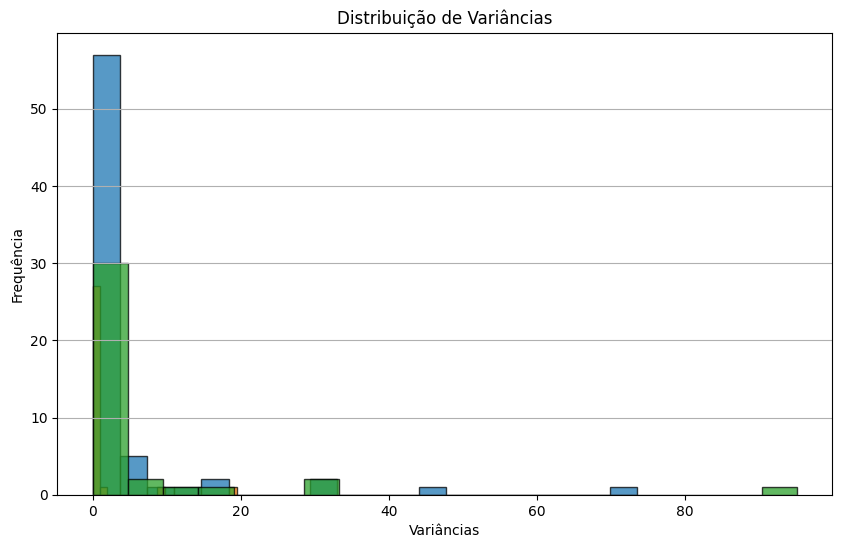

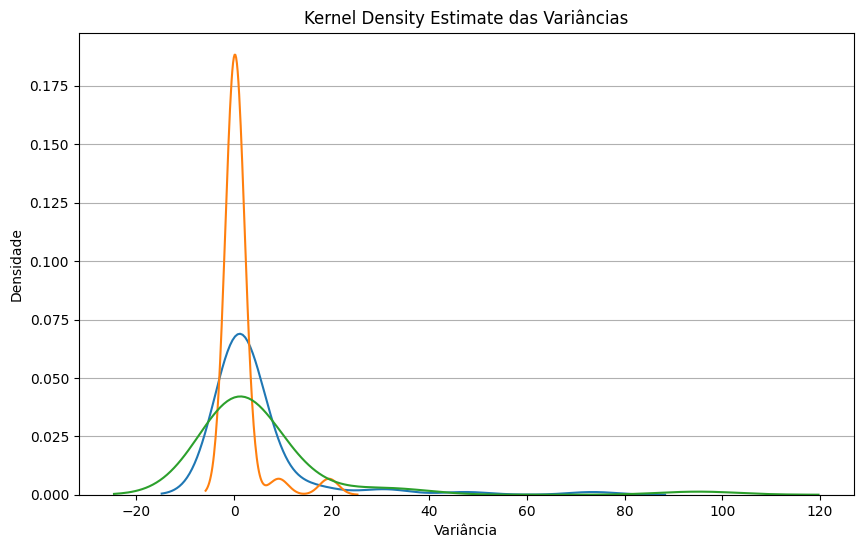

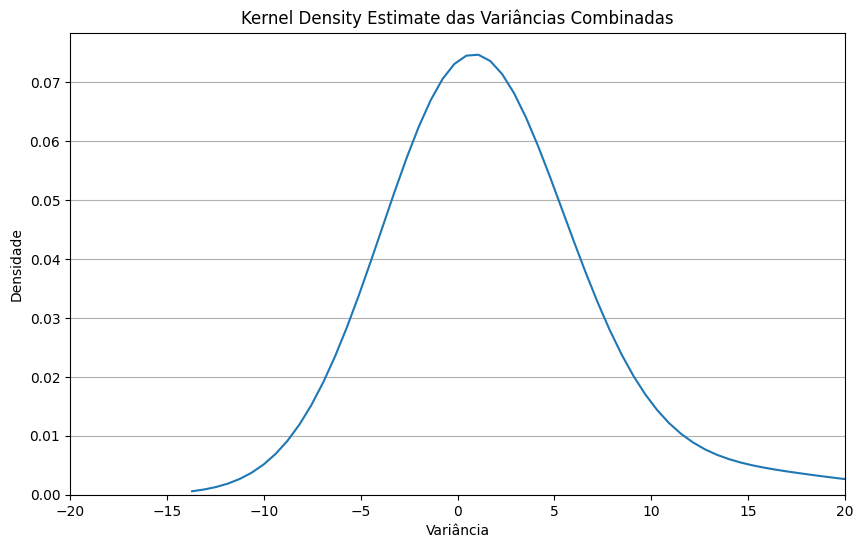

In [ ]:
# plot the histogram and distribution for the combinations variance
plt.figure(figsize=(10, 6))
plt.hist(df_same_quantities["Preço Var"], bins=20, alpha=0.75, edgecolor='black')
plt.hist(df_same_quantities_2["Preço Var"], bins=20, alpha=0.75, edgecolor='black')
plt.hist(df_same_quantities_3["Preço Var"], bins=20, alpha=0.75, edgecolor='black')

plt.title('Distribuição de Variâncias')
plt.xlabel('Variâncias')
plt.ylabel('Frequência')
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(df_same_quantities["Preço Var"], bw_adjust=1)
sns.kdeplot(df_same_quantities_2["Preço Var"], bw_adjust=1)
sns.kdeplot(df_same_quantities_3["Preço Var"], bw_adjust=1)
plt.title('Kernel Density Estimate das Variâncias')
plt.xlabel('Variância')
plt.ylabel('Densidade')
plt.grid(axis='y')
plt.show()

combined_preco_var = pd.concat([df_same_quantities["Preço Var"],
                                df_same_quantities_2["Preço Var"],
                                df_same_quantities_3["Preço Var"]])

plt.figure(figsize=(10, 6))
sns.kdeplot(combined_preco_var, bw_adjust=1)
plt.title('Kernel Density Estimate das Variâncias Combinadas')
plt.xlabel('Variância')
plt.ylabel('Densidade')
plt.grid(axis='y')
plt.xlim([-20, 20])
plt.show()